# Bonus Analysis

This notebook covers the bonus tasks:
1.  **Embedding Visualization**: Using UMAP to visualize sentence embeddings.
2.  **LLM Few-Shot Classification**: Using GPT-4 (or similar) for sentiment analysis via prompting.

In [1]:
import sys
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import umap
from sentence_transformers import SentenceTransformer

# Add src to path
sys.path.append(os.path.abspath(os.path.join('..', 'src')))

from data_loader import load_and_split_data

## 1. Embedding Visualization (UMAP)

Loading dataset: takala/financial_phrasebank (sentences_allagree)


Using the latest cached version of the dataset since takala/financial_phrasebank couldn't be found on the Hugging Face Hub
Found the latest cached dataset configuration 'sentences_allagree' at /Users/stefanbinkert/.cache/huggingface/datasets/takala___financial_phrasebank/sentences_allagree/1.0.0/550bde12e6c30e2674da973a55f57edde5181d53f5a5a34c1531c53f93b7e141 (last modified on Tue Nov 25 21:04:35 2025).


Total samples: 2264
Test size: 453
Validation size: 182
Training pool size: 1629
Created split 'train_100': 100 samples
Created split 'unlabeled_100': 1529 samples
Created split 'train_250': 250 samples
Created split 'unlabeled_250': 1379 samples
Created split 'train_500': 500 samples
Created split 'unlabeled_500': 1129 samples
Created split 'train_1000': 1000 samples
Created split 'unlabeled_1000': 629 samples


Batches:   0%|          | 0/15 [00:00<?, ?it/s]

/Users/stefanbinkert/Documents/FHNW_DS/NPR/NPR_MC_2/.venv/lib/python3.11/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


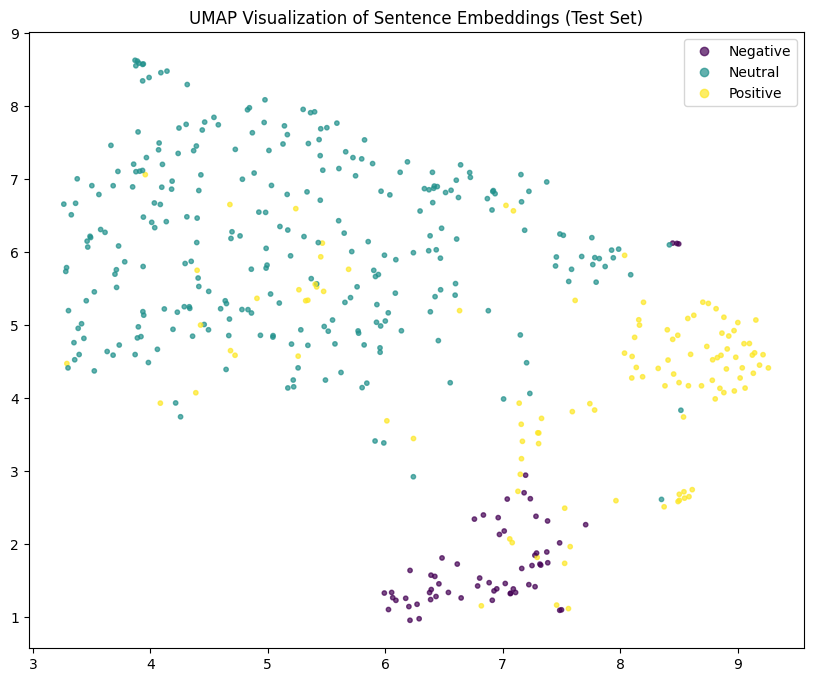

In [2]:
splits = load_and_split_data()
test_df = splits['test']

# Generate embeddings for test set
model = SentenceTransformer("all-mpnet-base-v2")
embeddings = model.encode(test_df['sentence'].tolist(), show_progress_bar=True)

# Reduce dimensionality with UMAP
reducer = umap.UMAP(n_neighbors=15, min_dist=0.1, random_state=42)
embedding_2d = reducer.fit_transform(embeddings)

# Plot
plt.figure(figsize=(10, 8))
scatter = plt.scatter(embedding_2d[:, 0], embedding_2d[:, 1], c=test_df['label'], cmap='viridis', s=10, alpha=0.7)
plt.legend(handles=scatter.legend_elements()[0], labels=['Negative', 'Neutral', 'Positive'])
plt.title('UMAP Visualization of Sentence Embeddings (Test Set)')
plt.show()

## 2. LLM Few-Shot Classification

**Note**: This requires an OpenAI API key. Please set `OPENAI_API_KEY` environment variable.

In [3]:
# Ensure test_df is loaded if this cell is run independently
if 'test_df' not in locals():
    print("test_df not found. Loading data...")
    if 'load_and_split_data' not in locals():
        import sys
        import os
        # Adjust path if needed, assuming notebook is in notebooks/
        if os.path.abspath(os.path.join('..', 'src')) not in sys.path:
            sys.path.append(os.path.abspath(os.path.join('..', 'src')))
        from data_loader import load_and_split_data
    
    splits = load_and_split_data()
    test_df = splits['test']
    print("Data loaded.")

import os
import openai
from sklearn.metrics import accuracy_score

api_key = os.getenv("OPENAI_API_KEY")

if api_key:
    client = openai.OpenAI(api_key=api_key)
    
    def classify_with_llm(sentence):
        prompt = f"""
        You are a financial sentiment analysis assistant.
        Classify the sentiment of the following financial news sentence as Positive, Negative, or Neutral.
        Provide the label only.
        
        Examples:
        Sentence: "The company's profits surged by 50% this quarter."
        Sentiment: Positive
        
        Sentence: "The CEO resigned amidst a major scandal."
        Sentiment: Negative
        
        Sentence: "The company announced a new product line."
        Sentiment: Neutral
        
        Sentence: "{sentence}"
        Sentiment:
        """
        
        response = client.responses.create(
            model="gpt-5.1",
            reasoning={"effort": "none"},
            input=prompt
        )
        return response.output_text

    # Run on a small subset of test data
    subset_test = test_df.head(20).copy()
    subset_test['llm_pred'] = subset_test['sentence'].apply(classify_with_llm)
    
    # Map text labels to integers if needed, or compare text
    label_map = {'Negative': 0, 'Neutral': 1, 'Positive': 2}
    subset_test['llm_pred_int'] = subset_test['llm_pred'].map(label_map)
    
    acc = accuracy_score(subset_test['label'], subset_test['llm_pred_int'])
    print(f"LLM Few-Shot Accuracy (on 20 samples): {acc:.4f}")
    
else:
    print("OPENAI_API_KEY not found. Skipping LLM classification.")

LLM Few-Shot Accuracy (on 20 samples): 0.9500
